In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor


In [3]:
import glob

chasedb1_path = '/media/mountHDD2/chasedb1'

image_files = glob.glob(chasedb1_path + '/*.jpg')
mask_files = glob.glob(chasedb1_path + '/*1stHO.png')

image_files.sort()
mask_files.sort()

img_dir = []
mask_dir = []

# Tạo danh sách các cặp (image, mask)
image_mask_pairs = [(image, mask) for image, mask in zip(image_files, mask_files)]

for pair in image_mask_pairs:
    img_dir.append(pair[0])  
    mask_dir.append(pair[1]) 

In [4]:
class ChasedbT(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, target_transform=None):
        self.imgs = img_dir  
        self.msks = mask_dir 
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        msk_path = self.msks[idx]

        img = Image.open(img_path)
        msk = Image.open(msk_path)

        if self.transform:
            img = self.transform(img)

        if self.target_transform:
            msk = self.target_transform(msk)

        return (img, msk)

In [5]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        #transforms.RandomResizedCrop(size=(224, 224), antialias=True),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #The mean and std of ImageNet,Medical images must be counted separately 
    ]
)
#https://www.geeksforgeeks.org/how-to-normalize-images-in-pytorch/

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

Data_transfered = ChasedbT( img_dir=img_dir, mask_dir=mask_dir,transform = transform, target_transform=target_transform)
print(len(Data_transfered))

28


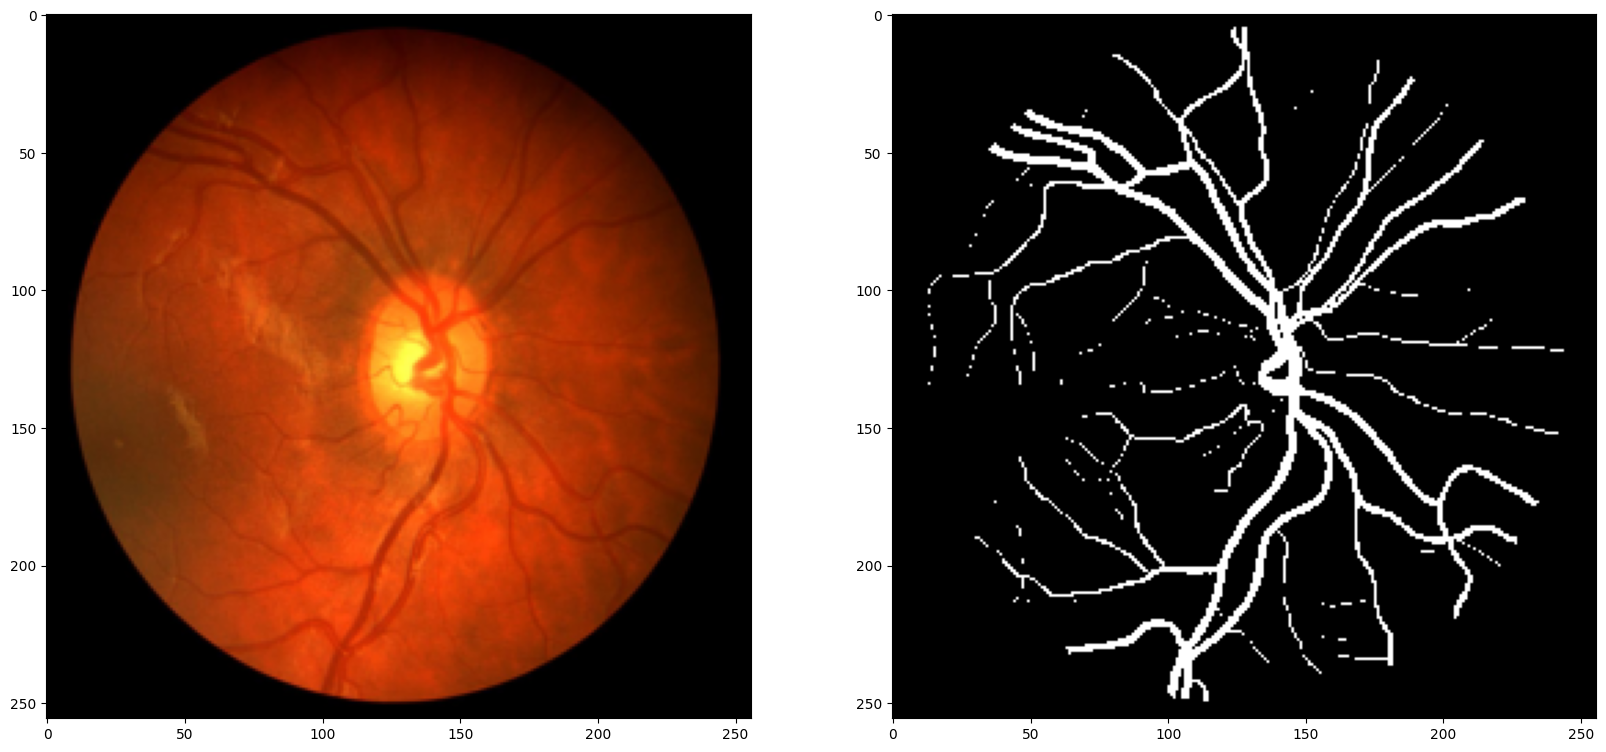

In [6]:

img, msk = Data_transfered[5]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20)) #tạo một figure chứa hai axes (ax1 và ax2) được sắp xếp theo hàng ngang với kích thước 20x20 inches
ax1.imshow(img.permute(1, -1, 0).numpy()) #Phương thức permute(1, -1, 0) được sử dụng để thay đổi chiều của tensor ,.numpy() chuyển đổi tensor thành mảng NumPy
ax2.imshow(msk.permute(1, -1, 0).numpy(), cmap = 'gray')

In [7]:
from torch.utils.data.dataset import random_split
train_ds, test_ds = random_split(Data_transfered, [0.8, 0.2])

train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=True)

print("Training Samples: {}".format(len(train_ds)))
print("Testing Samples: {}".format(len(test_ds)))

Training Samples: 23
Testing Samples: 5


***Training***

In [8]:
class conv_block_nested(nn.Module):
    
    def __init__(self, in_ch, mid_ch, out_ch):
        super(conv_block_nested, self).__init__()
        self.activation = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(mid_ch)
        self.conv2 = nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        output = self.activation(x)

        return output

In [9]:
class NestedUNet(nn.Module):
    """
    Implementation of this paper:
    https://arxiv.org/pdf/1807.10165.pdf
    """
    def __init__(self, in_ch=3, out_ch=3, init_channel=16):
        super(NestedUNet, self).__init__()

        n1 = init_channel
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = conv_block_nested(in_ch, filters[0], filters[0])
        self.conv1_0 = conv_block_nested(filters[0], filters[1], filters[1])
        self.conv2_0 = conv_block_nested(filters[1], filters[2], filters[2])
        self.conv3_0 = conv_block_nested(filters[2], filters[3], filters[3])
        self.conv4_0 = conv_block_nested(filters[3], filters[4], filters[4])

        self.conv0_1 = conv_block_nested(filters[0] + filters[1], filters[0], filters[0])
        self.conv1_1 = conv_block_nested(filters[1] + filters[2], filters[1], filters[1])
        self.conv2_1 = conv_block_nested(filters[2] + filters[3], filters[2], filters[2])
        self.conv3_1 = conv_block_nested(filters[3] + filters[4], filters[3], filters[3])

        self.conv0_2 = conv_block_nested(filters[0]*2 + filters[1], filters[0], filters[0])
        self.conv1_2 = conv_block_nested(filters[1]*2 + filters[2], filters[1], filters[1])
        self.conv2_2 = conv_block_nested(filters[2]*2 + filters[3], filters[2], filters[2])

        self.conv0_3 = conv_block_nested(filters[0]*3 + filters[1], filters[0], filters[0])
        self.conv1_3 = conv_block_nested(filters[1]*3 + filters[2], filters[1], filters[1])

        self.conv0_4 = conv_block_nested(filters[0]*4 + filters[1], filters[0], filters[0])

        self.final = nn.Conv2d(filters[0], out_ch, kernel_size=1)


    def forward(self, x):
        
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.Up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.Up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.Up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.Up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.Up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.Up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.Up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.Up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.Up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.Up(x1_3)], 1))

        output = self.final(x0_4)
        return output

In [10]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [11]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    #Hàm này tính toán hệ số Dice giữa dự đoán (input) và mục tiêu (target),được sử dụng để đánh giá độ tương đồng giữa hai mẫu dữ liệu nhị phân
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    #Hàm này tính toán hệ số Dice đa lớp cho từng lớp trong mô hình. Thường được sử dụng khi có nhiều lớp cần đánh giá
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    #Hàm này tính toán mất mát Dice, là giá trị cần tối thiểu hóa trong quá trình huấn luyện mô hình. Mất mát Dice được tính bằng công thức 1 - hệ số Dic
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [16]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)
#device = torch.device("cpu")
model = NestedUNet(3,1,16).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

loss_fn = nn.BCEWithLogitsLoss()

In [17]:
old_loss = 1e26
best_dct = None
last_dct = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    tr_total_dice = 0
    tr_total_iou = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)        
        train_loss = loss_fn(train_gen_mask, train_mask)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()        
        
        tr_total_loss += train_loss.cpu().item()        
            
    mean_train_loss = tr_total_loss/len(train_dl)

    if mean_train_loss <= old_loss:
        old_loss = mean_train_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss}")
model.load_state_dict(best_dct)

100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 15.19it/s]


Epoch: 0 - TrainLoss: 0.621320763359899


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.42it/s]


Epoch: 1 - TrainLoss: 0.4870392356229865


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.95it/s]


Epoch: 2 - TrainLoss: 0.41176151970158453


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.50it/s]


Epoch: 3 - TrainLoss: 0.35280741038529767


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.40it/s]


Epoch: 4 - TrainLoss: 0.3069365931593854


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.85it/s]


Epoch: 5 - TrainLoss: 0.2696140123450238


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.77it/s]


Epoch: 6 - TrainLoss: 0.23728561660517816


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.35it/s]


Epoch: 7 - TrainLoss: 0.21169937693554422


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.42it/s]


Epoch: 8 - TrainLoss: 0.19249170435511548


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.89it/s]


Epoch: 9 - TrainLoss: 0.17252466406511224


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.72it/s]


Epoch: 10 - TrainLoss: 0.15981847825257675


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.98it/s]


Epoch: 11 - TrainLoss: 0.14783089122046594


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.39it/s]


Epoch: 12 - TrainLoss: 0.1364934424991193


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.53it/s]


Epoch: 13 - TrainLoss: 0.12719703044580377


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.02it/s]


Epoch: 14 - TrainLoss: 0.11879627795323082


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.55it/s]


Epoch: 15 - TrainLoss: 0.11276541131993999


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.33it/s]


Epoch: 16 - TrainLoss: 0.1070379174273947


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.46it/s]


Epoch: 17 - TrainLoss: 0.10346418975487999


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.07it/s]


Epoch: 18 - TrainLoss: 0.09820615014304286


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.36it/s]


Epoch: 19 - TrainLoss: 0.09470323894334876


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.34it/s]


Epoch: 20 - TrainLoss: 0.09287226588829704


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.00it/s]


Epoch: 21 - TrainLoss: 0.08987440428008205


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.96it/s]


Epoch: 22 - TrainLoss: 0.08707330958998721


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.51it/s]


Epoch: 23 - TrainLoss: 0.08331890274649081


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.35it/s]


Epoch: 24 - TrainLoss: 0.08144432435864987


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.54it/s]


Epoch: 25 - TrainLoss: 0.0792571643124456


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.79it/s]


Epoch: 26 - TrainLoss: 0.07602766156196594


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.35it/s]


Epoch: 27 - TrainLoss: 0.07380921166876088


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.44it/s]


Epoch: 28 - TrainLoss: 0.07171920395415762


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.24it/s]


Epoch: 29 - TrainLoss: 0.07200890909070554


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.65it/s]


Epoch: 30 - TrainLoss: 0.07143734557473141


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.66it/s]


Epoch: 31 - TrainLoss: 0.06804162069507268


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.63it/s]


Epoch: 32 - TrainLoss: 0.06786230870563051


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.71it/s]


Epoch: 33 - TrainLoss: 0.06606913017837898


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.43it/s]


Epoch: 34 - TrainLoss: 0.06274362880250682


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.39it/s]


Epoch: 35 - TrainLoss: 0.060914252115332565


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.84it/s]


Epoch: 36 - TrainLoss: 0.059061723396829933


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.16it/s]


Epoch: 37 - TrainLoss: 0.05831446498632431


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.15it/s]


Epoch: 38 - TrainLoss: 0.056659545263518456


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.88it/s]


Epoch: 39 - TrainLoss: 0.05559750371005224


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.44it/s]


Epoch: 40 - TrainLoss: 0.054457032648117645


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.03it/s]


Epoch: 41 - TrainLoss: 0.05230321378811546


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.07it/s]


Epoch: 42 - TrainLoss: 0.05190984499843224


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.72it/s]


Epoch: 43 - TrainLoss: 0.05159134709316751


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.86it/s]


Epoch: 44 - TrainLoss: 0.050651343134434326


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.15it/s]


Epoch: 45 - TrainLoss: 0.048413232130848846


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.31it/s]


Epoch: 46 - TrainLoss: 0.04691115361840829


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.51it/s]


Epoch: 47 - TrainLoss: 0.04494982277569563


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.38it/s]


Epoch: 48 - TrainLoss: 0.04373278906163962


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.44it/s]


Epoch: 49 - TrainLoss: 0.042927232287500214


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.07it/s]


Epoch: 50 - TrainLoss: 0.04212761556972628


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.58it/s]


Epoch: 51 - TrainLoss: 0.04237395265828008


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.02it/s]


Epoch: 52 - TrainLoss: 0.040100464354390686


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.48it/s]


Epoch: 53 - TrainLoss: 0.04065248904668767


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.66it/s]


Epoch: 54 - TrainLoss: 0.04276204028207323


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.50it/s]


Epoch: 55 - TrainLoss: 0.037868686992189156


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 45.58it/s]


Epoch: 56 - TrainLoss: 0.03588832866238511


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 42.56it/s]


Epoch: 57 - TrainLoss: 0.035214745723035026


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 37.58it/s]


Epoch: 58 - TrainLoss: 0.03511529707390329


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 46.73it/s]


Epoch: 59 - TrainLoss: 0.03483873119820719


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 43.36it/s]


Epoch: 60 - TrainLoss: 0.03511101047953834


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 43.71it/s]


Epoch: 61 - TrainLoss: 0.03250714148516241


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.16it/s]


Epoch: 62 - TrainLoss: 0.03213458265299383


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.80it/s]


Epoch: 63 - TrainLoss: 0.032237639002825905


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.22it/s]


Epoch: 64 - TrainLoss: 0.031475287821629776


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.34it/s]


Epoch: 65 - TrainLoss: 0.03031532191064047


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.27it/s]


Epoch: 66 - TrainLoss: 0.030290938508899315


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.20it/s]


Epoch: 67 - TrainLoss: 0.028980158674328224


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.99it/s]


Epoch: 68 - TrainLoss: 0.027807942065207855


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.96it/s]


Epoch: 69 - TrainLoss: 0.027869371697306633


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.38it/s]


Epoch: 70 - TrainLoss: 0.028560200706124306


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.57it/s]


Epoch: 71 - TrainLoss: 0.027878111633269684


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.18it/s]


Epoch: 72 - TrainLoss: 0.025693438461293346


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.14it/s]


Epoch: 73 - TrainLoss: 0.024242951818134472


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.03it/s]


Epoch: 74 - TrainLoss: 0.023560381858893063


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.55it/s]


Epoch: 75 - TrainLoss: 0.023553707434431366


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.34it/s]


Epoch: 76 - TrainLoss: 0.022699752741533775


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.84it/s]


Epoch: 77 - TrainLoss: 0.021278831216952076


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.45it/s]


Epoch: 78 - TrainLoss: 0.02048370930487695


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.70it/s]


Epoch: 79 - TrainLoss: 0.020354783162474632


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.02it/s]


Epoch: 80 - TrainLoss: 0.019626484454973885


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.59it/s]


Epoch: 81 - TrainLoss: 0.02018437858508981


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.19it/s]


Epoch: 82 - TrainLoss: 0.020626310745011204


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.36it/s]


Epoch: 83 - TrainLoss: 0.02241986860399661


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.49it/s]


Epoch: 84 - TrainLoss: 0.022270280705845875


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.06it/s]


Epoch: 85 - TrainLoss: 0.020427437661134678


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.23it/s]


Epoch: 86 - TrainLoss: 0.018458934581798057


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.54it/s]


Epoch: 87 - TrainLoss: 0.01704839434798645


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.15it/s]


Epoch: 88 - TrainLoss: 0.016309535697750423


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.75it/s]


Epoch: 89 - TrainLoss: 0.016265910321279713


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.41it/s]


Epoch: 90 - TrainLoss: 0.015887281654969505


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.81it/s]


Epoch: 91 - TrainLoss: 0.015143562877631706


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 37.22it/s]


Epoch: 92 - TrainLoss: 0.015286144274084465


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.01it/s]


Epoch: 93 - TrainLoss: 0.018423528410494328


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.48it/s]


Epoch: 94 - TrainLoss: 0.017046731410791046


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.40it/s]


Epoch: 95 - TrainLoss: 0.016107645169224426


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.01it/s]


Epoch: 96 - TrainLoss: 0.014590768993872663


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.88it/s]


Epoch: 97 - TrainLoss: 0.015566562018964602


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.38it/s]


Epoch: 98 - TrainLoss: 0.01440856573374375


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.03it/s]

Epoch: 99 - TrainLoss: 0.013036460291756235


<All keys matched successfully>

In [18]:
torch.save(best_dct, 'parameter_nestedunet_v1.pth')


In [ ]:
best_model = NestedUNet() 
best_model.load_state_dict(torch.load('parameter_nestedunet_v1.pth'))


In [19]:
test_img_dir= '/home/chuyenmt/Chuyen_explore-Copy1/Test_Drive'

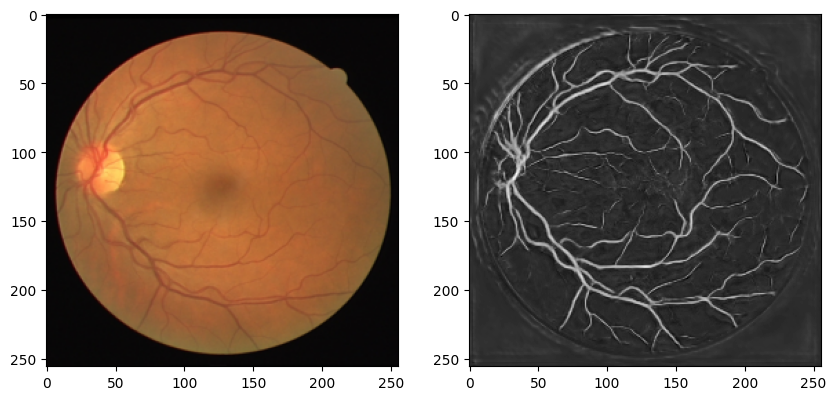

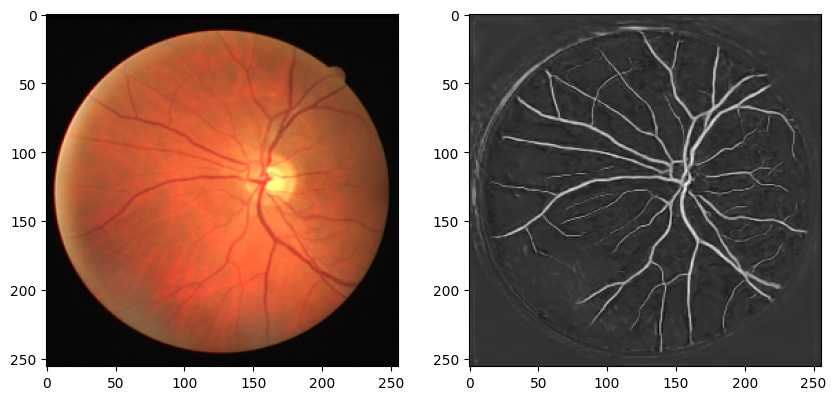

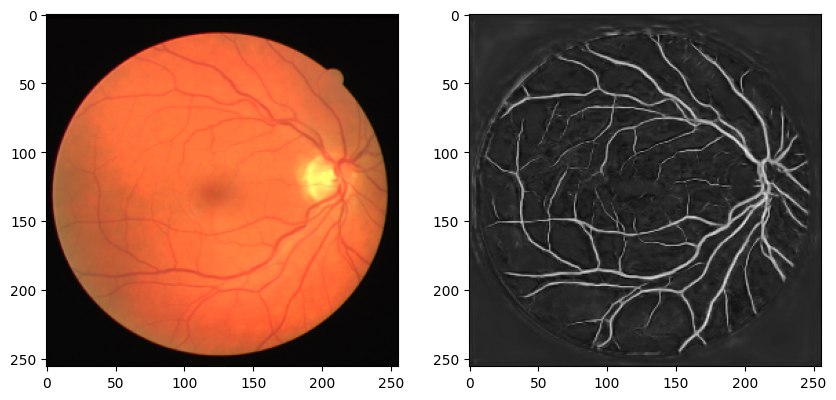

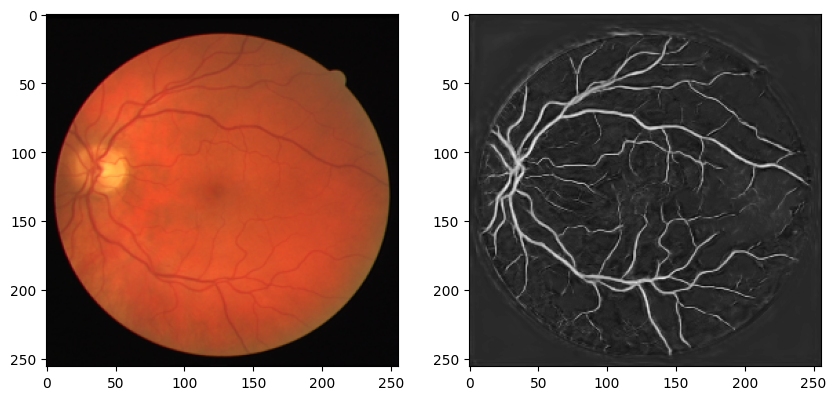

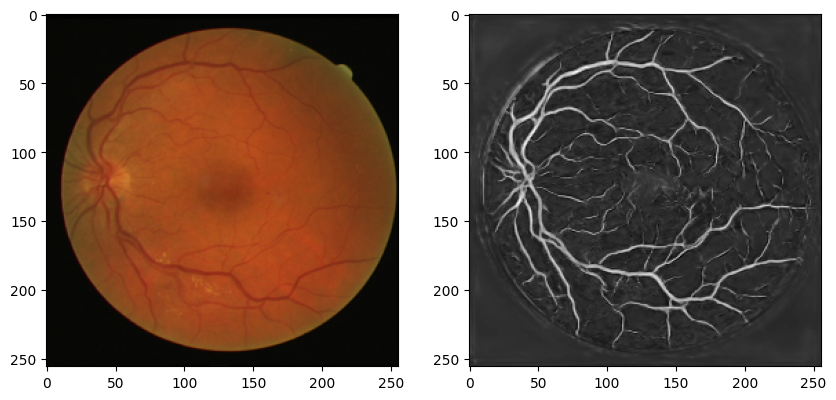

In [20]:
from glob import glob
for test_img_path in glob(test_img_dir + "/*"):
    img = transform(Image.open(test_img_path)).to(device).unsqueeze(0)

    mask = model(img)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

    ax1.imshow(img[0].permute(1, -1, 0).detach().cpu().numpy())
    ax2.imshow(mask[0].permute(1, -1, 0).detach().cpu().numpy(), cmap = 'gray')